In [1]:
from preprocessamento.SeriesProcessor import SeriesProcessor
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import pandas as pd
import numpy as np

In [2]:
# Função para comparar sub-janelas da janela principal com a última
def comparar_janelas_temporais(dados, n_janelas=4, alpha=0.05):
    tamanho = len(dados)
    parte = tamanho // n_janelas
    janelas = [dados[i*parte:(i+1)*parte] for i in range(n_janelas)]
    
    ultima = janelas[-1]
    similares = [ultima]
    for i in reversed(range(n_janelas - 1)):
        stat, p = ks_2samp(janelas[i], ultima)
        if p >= alpha:
            similares.insert(0, janelas[i])
        else:
            break
    return np.concatenate(similares), len(similares) * parte

In [3]:
# Baixando os dados da ação
serie_cortada = SeriesProcessor.carregar_serie_csv('IXIC')[:2000]

# Normalizando a série temporal
serie = SeriesProcessor.normalizar_serie(serie_cortada)
print(f"Shape da série após normalização: {serie.shape}")

Shape da série após normalização: (2000, 1)


In [4]:
# Parâmetros da janela deslizante
tamanho_janela = 100
n_janelas = 5
passo = 20

In [5]:
# Armazenar resultados
indices = []
tamanhos_segmentos = []

# Detectar drifts usando janelas deslizantes
for i in range(0, len(serie) - tamanho_janela + 1, passo):
    janela = serie[i:i + tamanho_janela]
    _, segmento_len = comparar_janelas_temporais(janela, n_janelas=n_janelas, alpha=0.05)
    indices.append(i + tamanho_janela)
    tamanhos_segmentos.append(segmento_len)

In [6]:
# Identificar os pontos onde houve mudança (drift)
mudancas = [idx for idx, tam in zip(indices[:-1], tamanhos_segmentos[:-1]) if tam < tamanho_janela]

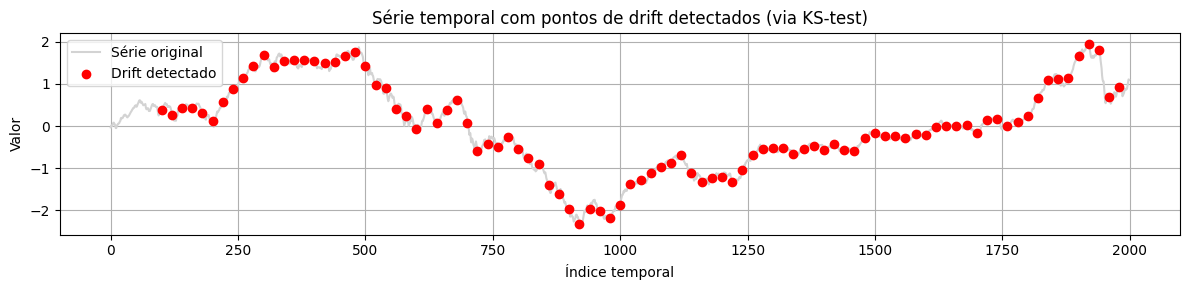

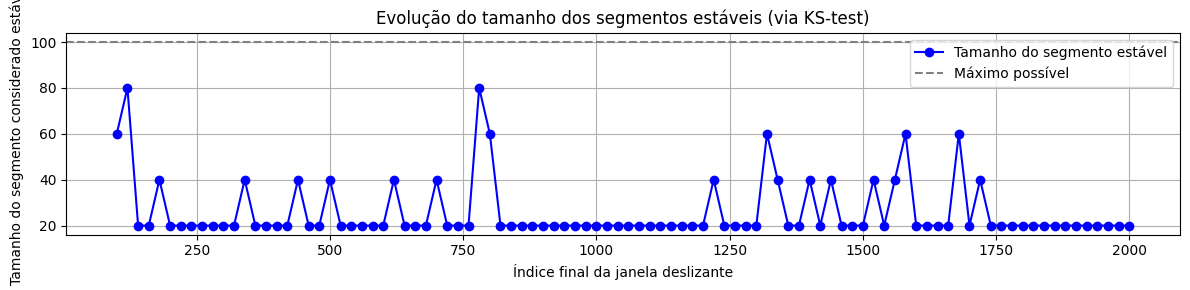

In [7]:
# === GRÁFICO 1: Série temporal com drifts destacados ===
plt.figure(figsize=(12, 3))
plt.plot(serie, color='lightgray', label='Série original')
plt.scatter(mudancas, serie[mudancas], color='red', zorder=5, label='Drift detectado')
plt.title('Série temporal com pontos de drift detectados (via KS-test)')
plt.xlabel('Índice temporal')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === GRÁFICO 2: Tamanho dos segmentos estáveis ===
plt.figure(figsize=(12, 3))
plt.plot(indices, tamanhos_segmentos, marker='o', linestyle='-', color='blue', label='Tamanho do segmento estável')
plt.axhline(y=tamanho_janela, color='gray', linestyle='--', label='Máximo possível')
plt.title('Evolução do tamanho dos segmentos estáveis (via KS-test)')
plt.xlabel('Índice final da janela deslizante')
plt.ylabel('Tamanho do segmento considerado estável')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()